In [1]:
import os
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
#import 
%matplotlib inline

In [2]:
base_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns'

era5_data_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\01_data\ERA_5_data'

data_name = 'NorthSea_April2025'
comparison_name = 'NorthSea_dx_comp'  # Name of the comparison
model_names = ['21_25_April_2025_dx_0point1', '21_25_April_2025_Base_case', '21_25_April_2025_dx_0point15']  # List of model names to compare

era5_file = os.path.join(era5_data_path, data_name,f'{data_name}_era5_data.nc')

era5_data = xu.open_dataset(era5_file)

base_name = model_names[0]
observed_names = model_names[1:]

# Paths to NetCDF history files
his_filepaths = [os.path.join(base_path, name, 'hurrywave_his.nc') for name in model_names]
map_filepaths = [os.path.join(base_path, name, 'hurrywave_map.nc') for name in model_names]


# Optional: Read station names from .obs file
obs_filepath = os.path.join(base_path, model_names[0], 'hurrywave.obs')





In [3]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

station_names= read_station_names_from_obs(obs_filepath)

In [4]:
print(station_names)

['Euro platform', 'Platform D15-A', 'Platform Hoorn Q1-A', 'North Cormorant', 'K13 Alpha', 'Platform F16-A', 'IJmuiden munitiestortplaats']


In [5]:
# --- Extract data using station names ---
def extract_data(ds: xr.Dataset, station_names):
    """
    Returns nested dictionary:
    data[station_name][variable_name] = values
    """
    station_dict = {}
    for i, station_idx in enumerate(ds.stations.values):
        station_name = station_names[i]
        station_data = ds.sel(stations=station_idx)
        station_dict[station_name] = {}

        for var in ds.data_vars:
            station_dict[station_name][var] = station_data[var].values

        for coord in ds.coords:
            station_dict[station_name][coord] = station_data[coord].values

    return station_dict

# --- Master structure: data[model_name][station_name][variable_name] ---
data = {}

for model_name, file_path in zip(model_names, his_filepaths):
    ds = xr.open_dataset(file_path)
    data[model_name] = extract_data(ds, station_names)

In [6]:
def plot_station_models_comparison(
    station_name,
    model_df,
    model_vars=None,
    models_to_plot=None
):
    """
    Plot time series for selected variables at a single station across multiple models.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
                         Structure: model_df[model][station][variable]
        model_vars (list): Variable names to include in the plot.
        models_to_plot (list): List of model names to plot. If None, plot all.
    """
    # Use first model to auto-detect variables if not provided
    example_model = next(iter(model_df))
    if model_vars is None:
        model_vars = list(model_df[example_model].get(station_name, {}).keys())

    if models_to_plot is None:
        models_to_plot = list(model_df.keys())

    n_vars = len(model_vars)

    fig = plt.figure(figsize=(14, 4 * n_vars + 5))
    fig.suptitle(f'Model Comparison at {station_name}', fontsize=16, y=1.03)  # Increased y for more space

    # --- Map plot with station location ---
    map_ax = fig.add_axes([0.15, 0.82, 0.7, 0.16])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Use lat/lon from the first model
    lat = float(model_df[example_model][station_name]["station_y"])
    lon = float(model_df[example_model][station_name]["station_x"])
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=8)
    map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

    # --- Time series plots ---
    for i, var in enumerate(model_vars):
        ax = fig.add_axes([0.10, 0.60 - i * 0.22, 0.85, 0.18])
        ax.grid(True)

        for model_name in models_to_plot:
            station_data = model_df.get(model_name, {})
            if station_name in station_data and var in station_data[station_name]:
                time = station_data[station_name]["time"]
                values = station_data[station_name][var]
                ax.plot(time, values, label=model_name)

        ax.set_title(var)
        ax.set_ylabel(var)
        if i == len(model_vars) - 1:
            ax.set_xlabel("Time")
        ax.legend()

    plt.show()

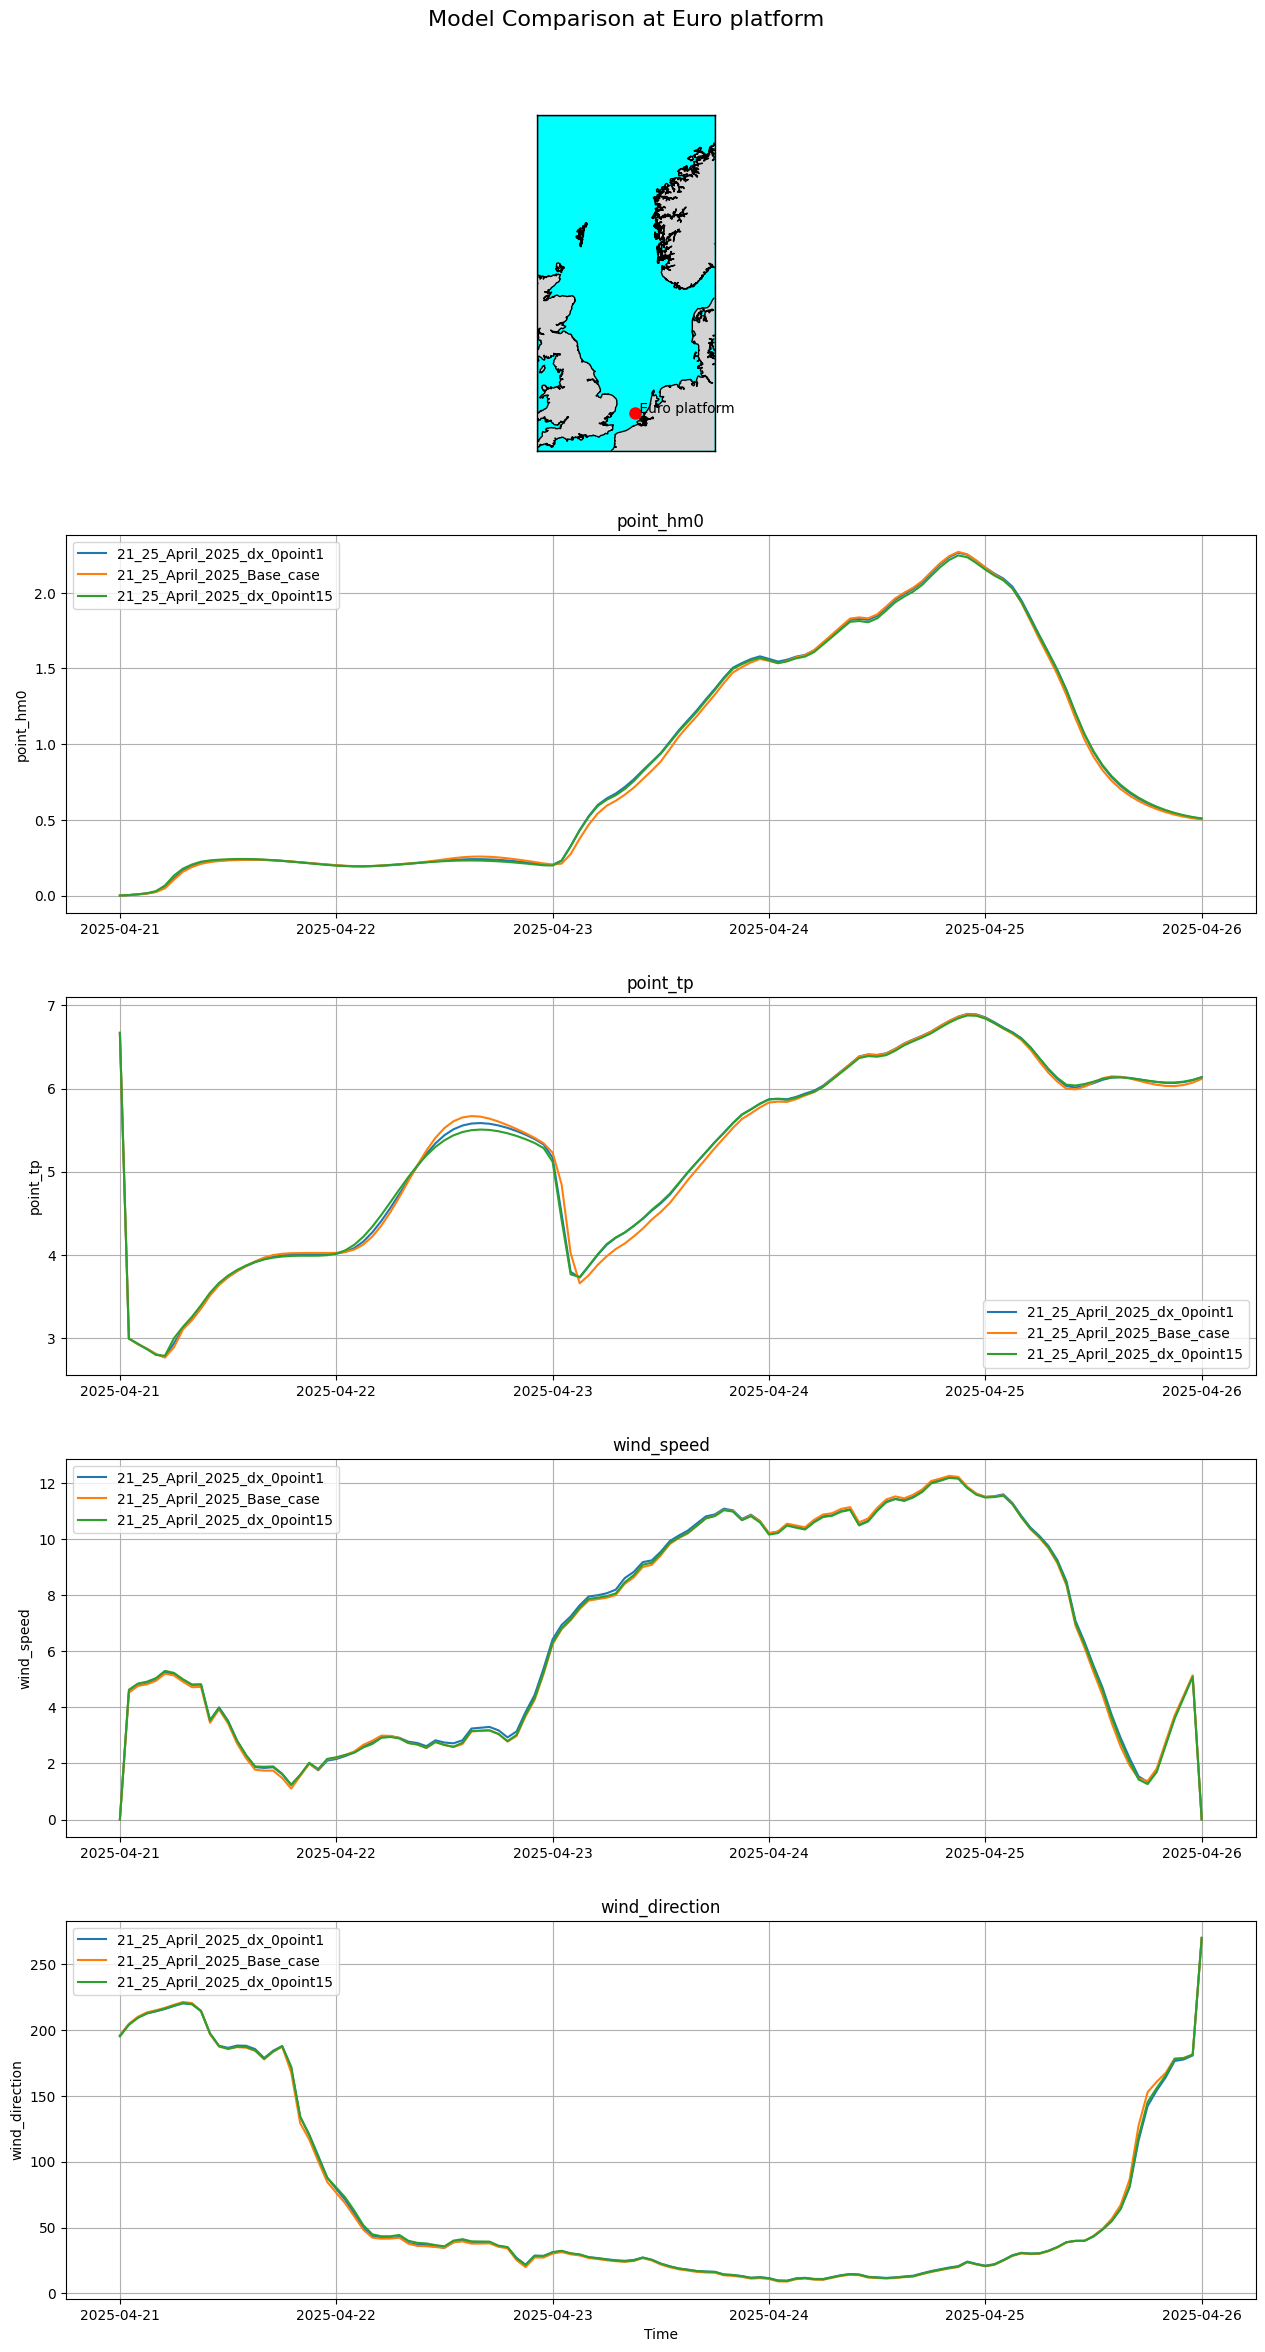

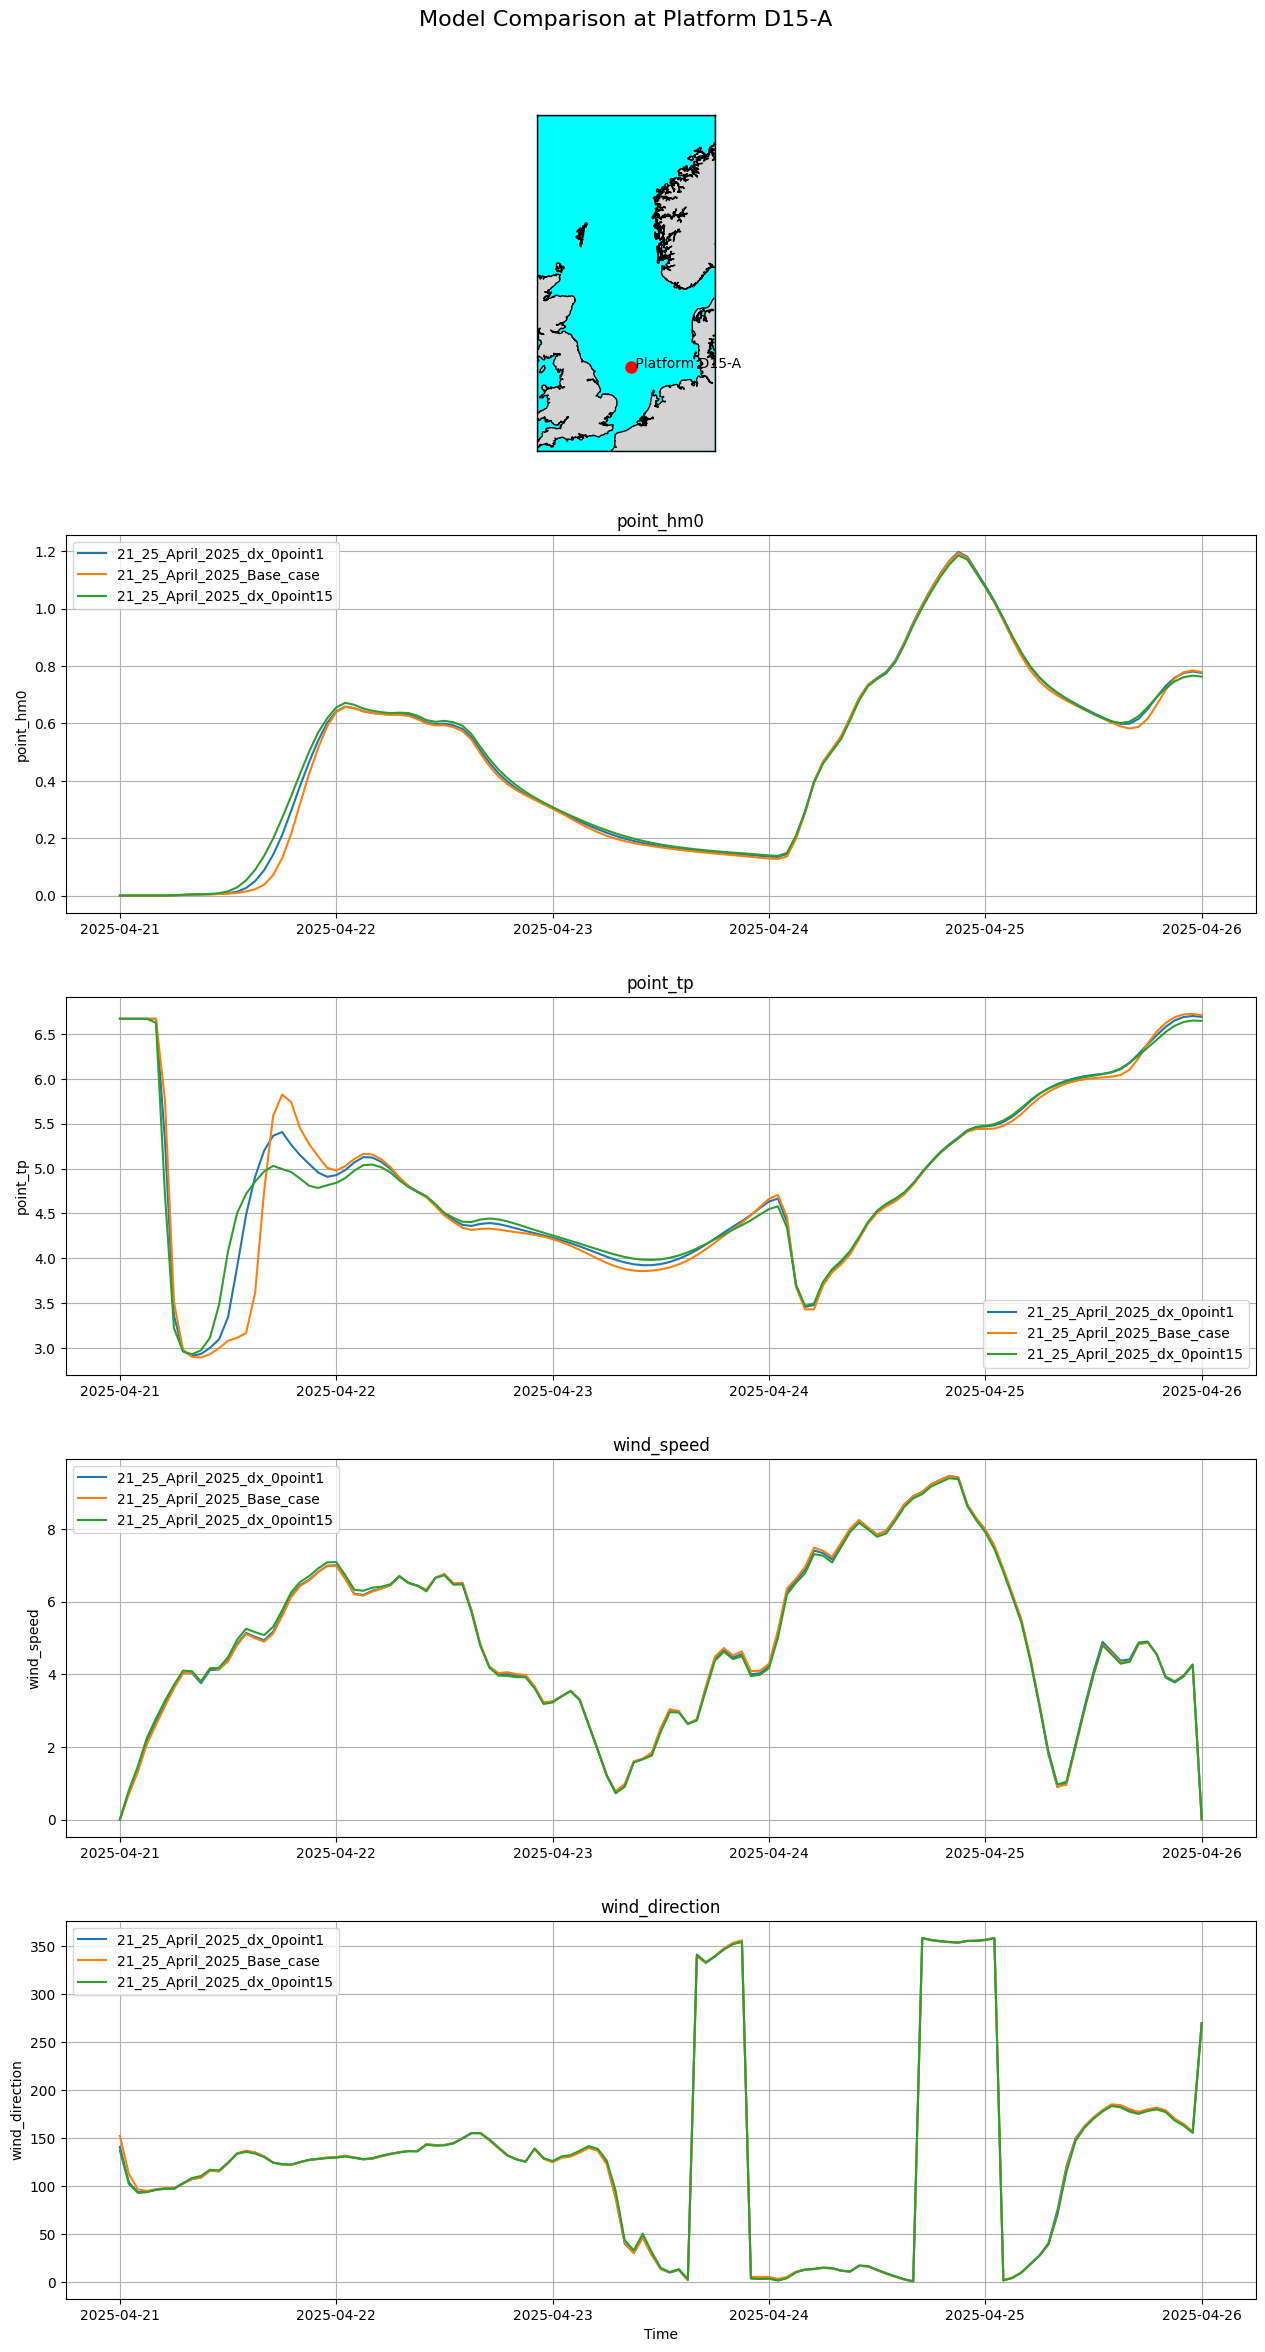

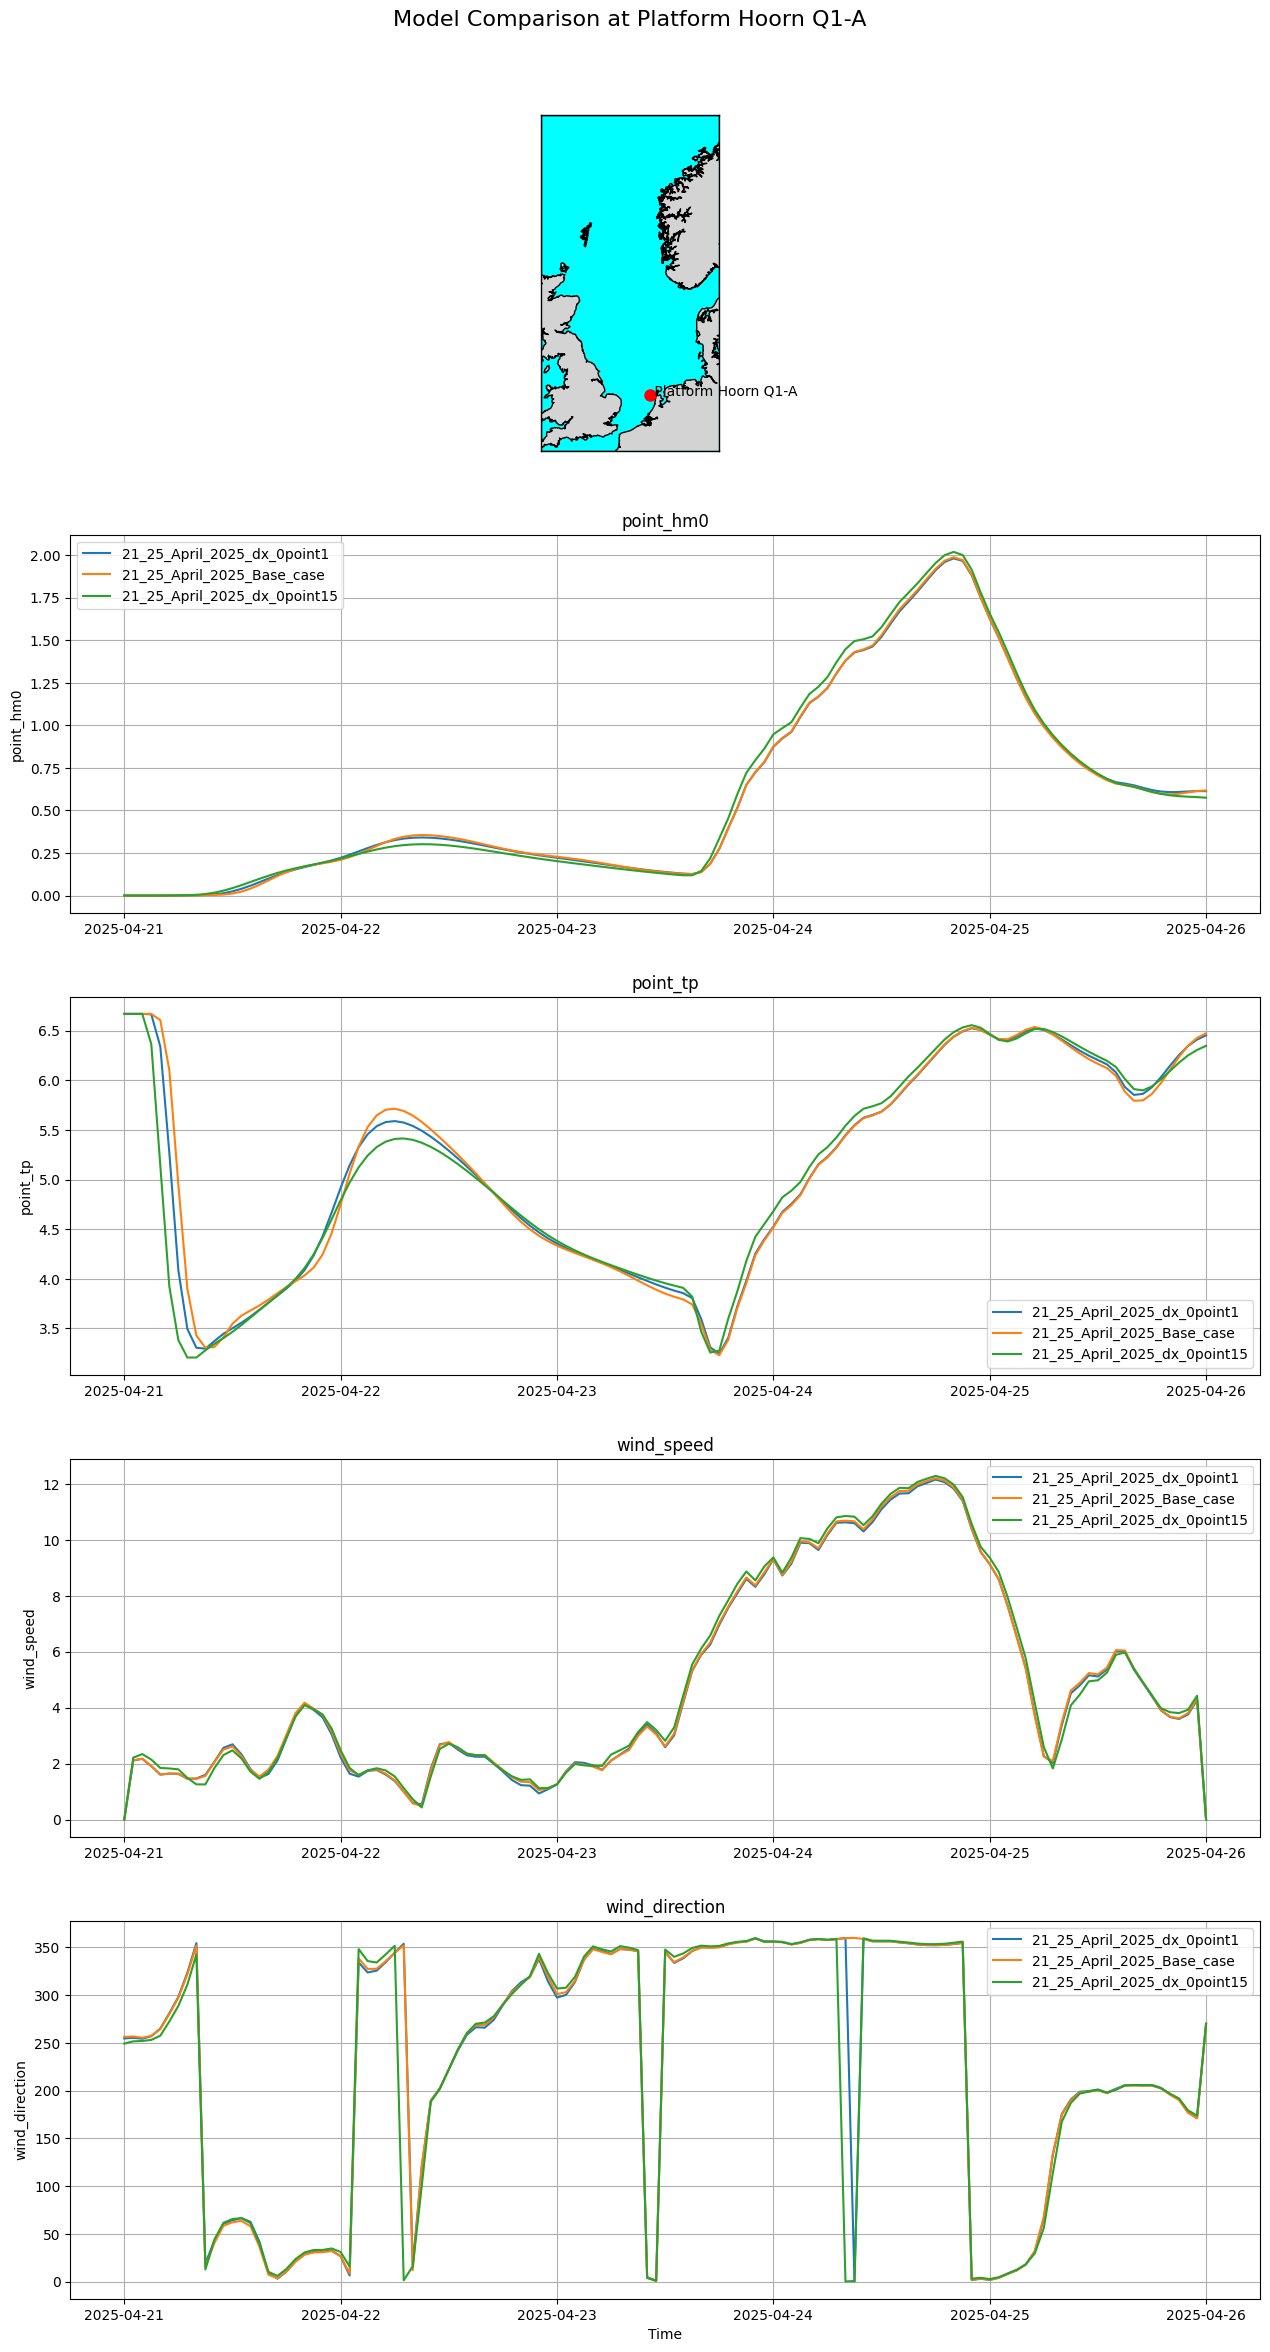

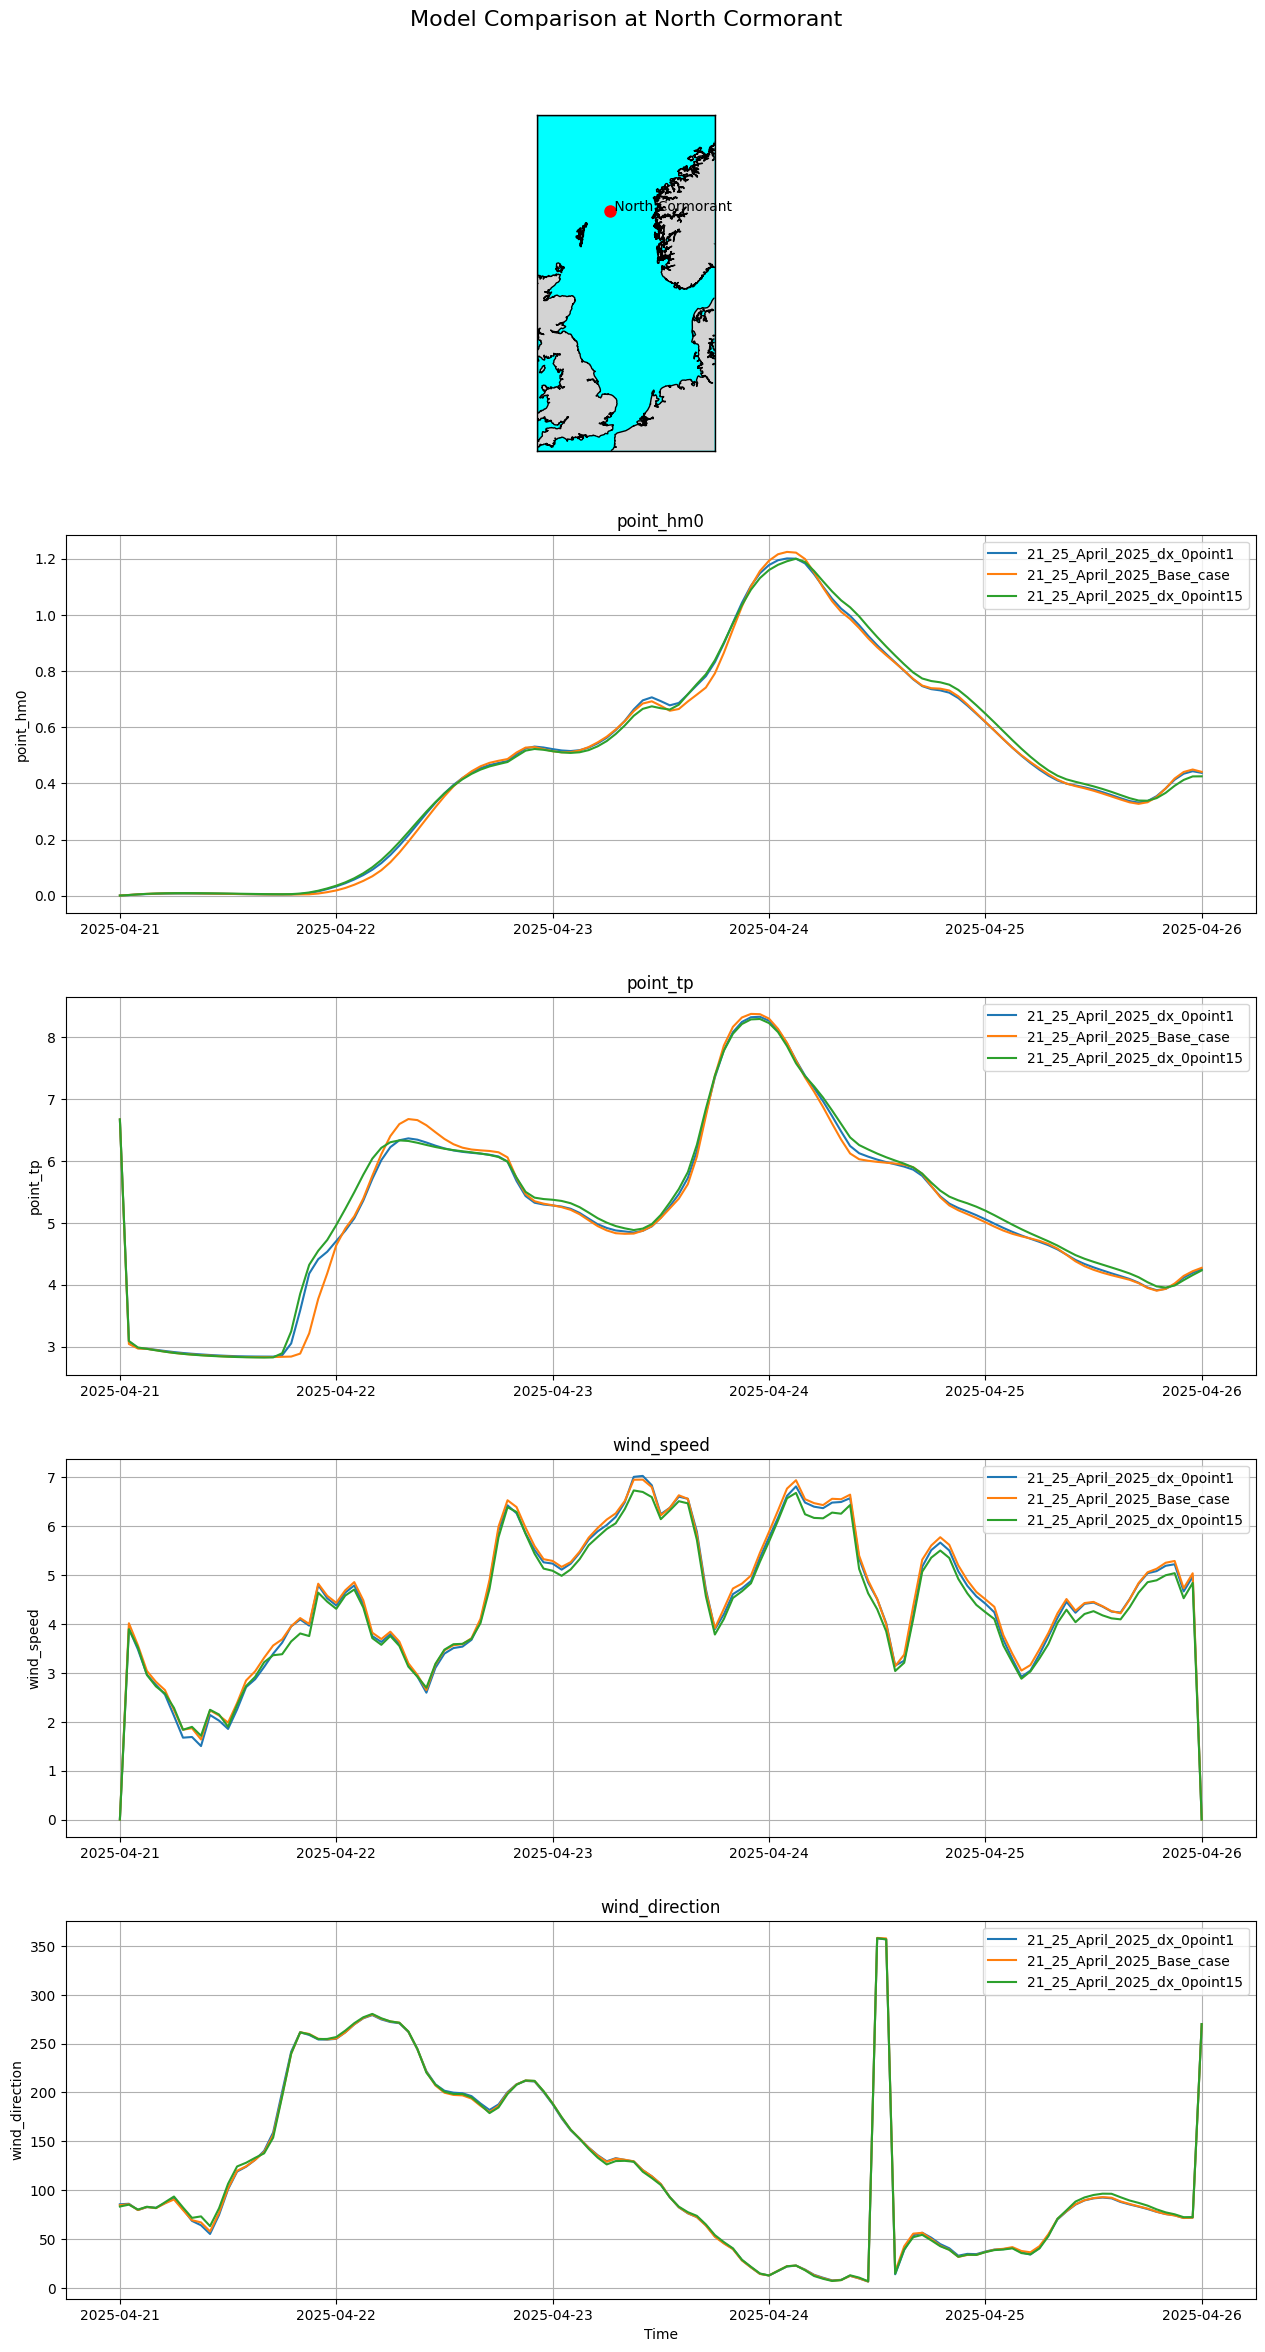

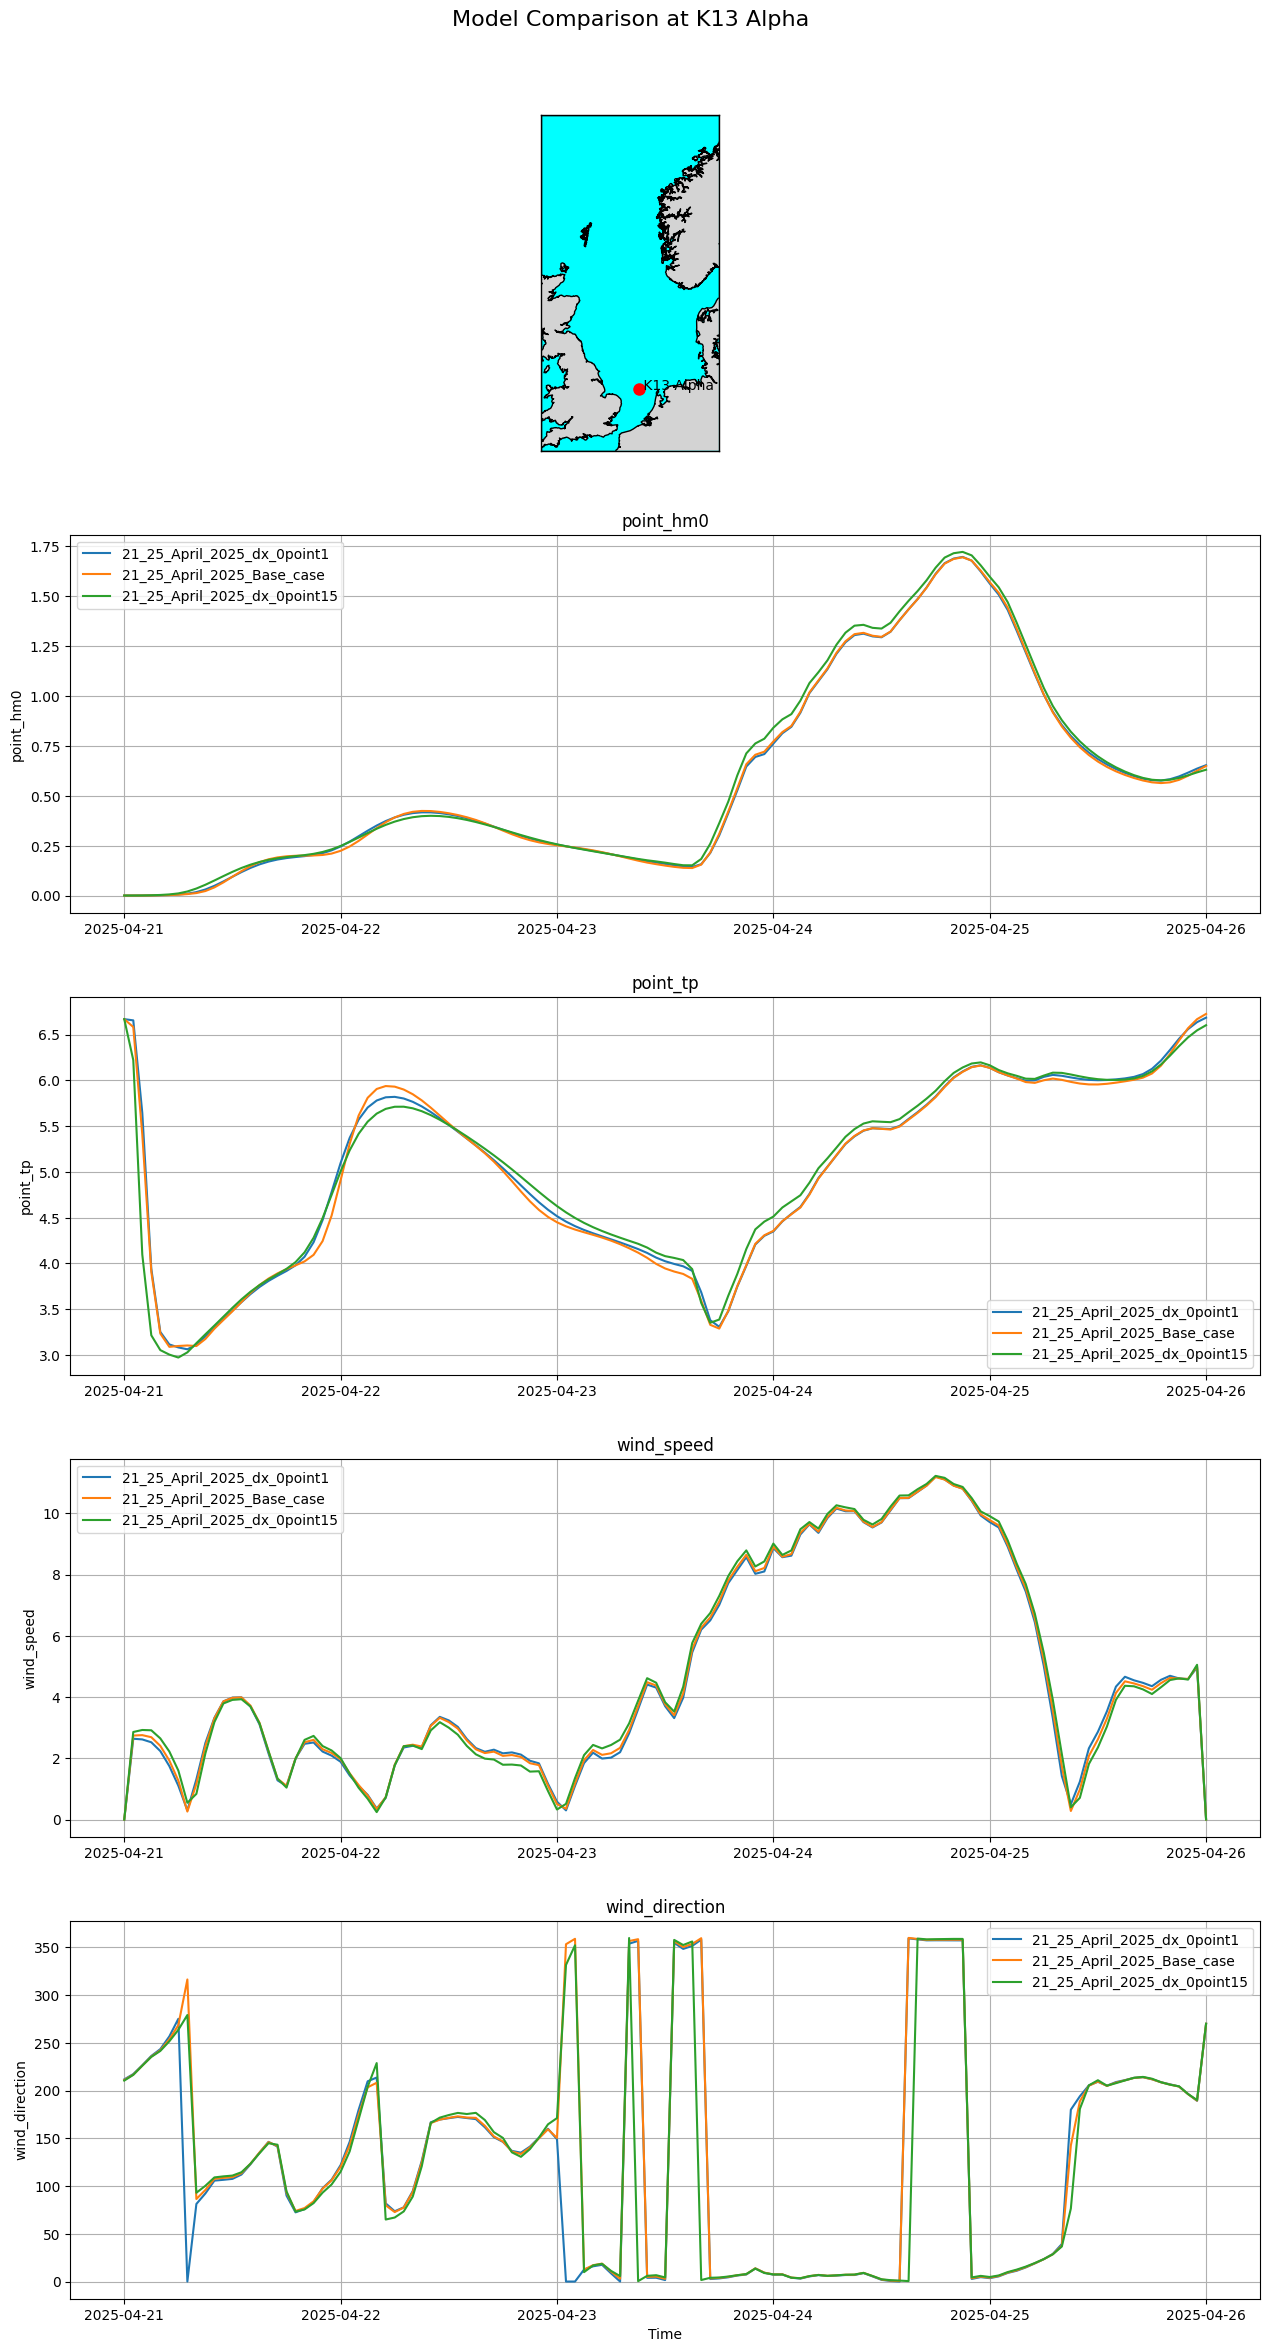

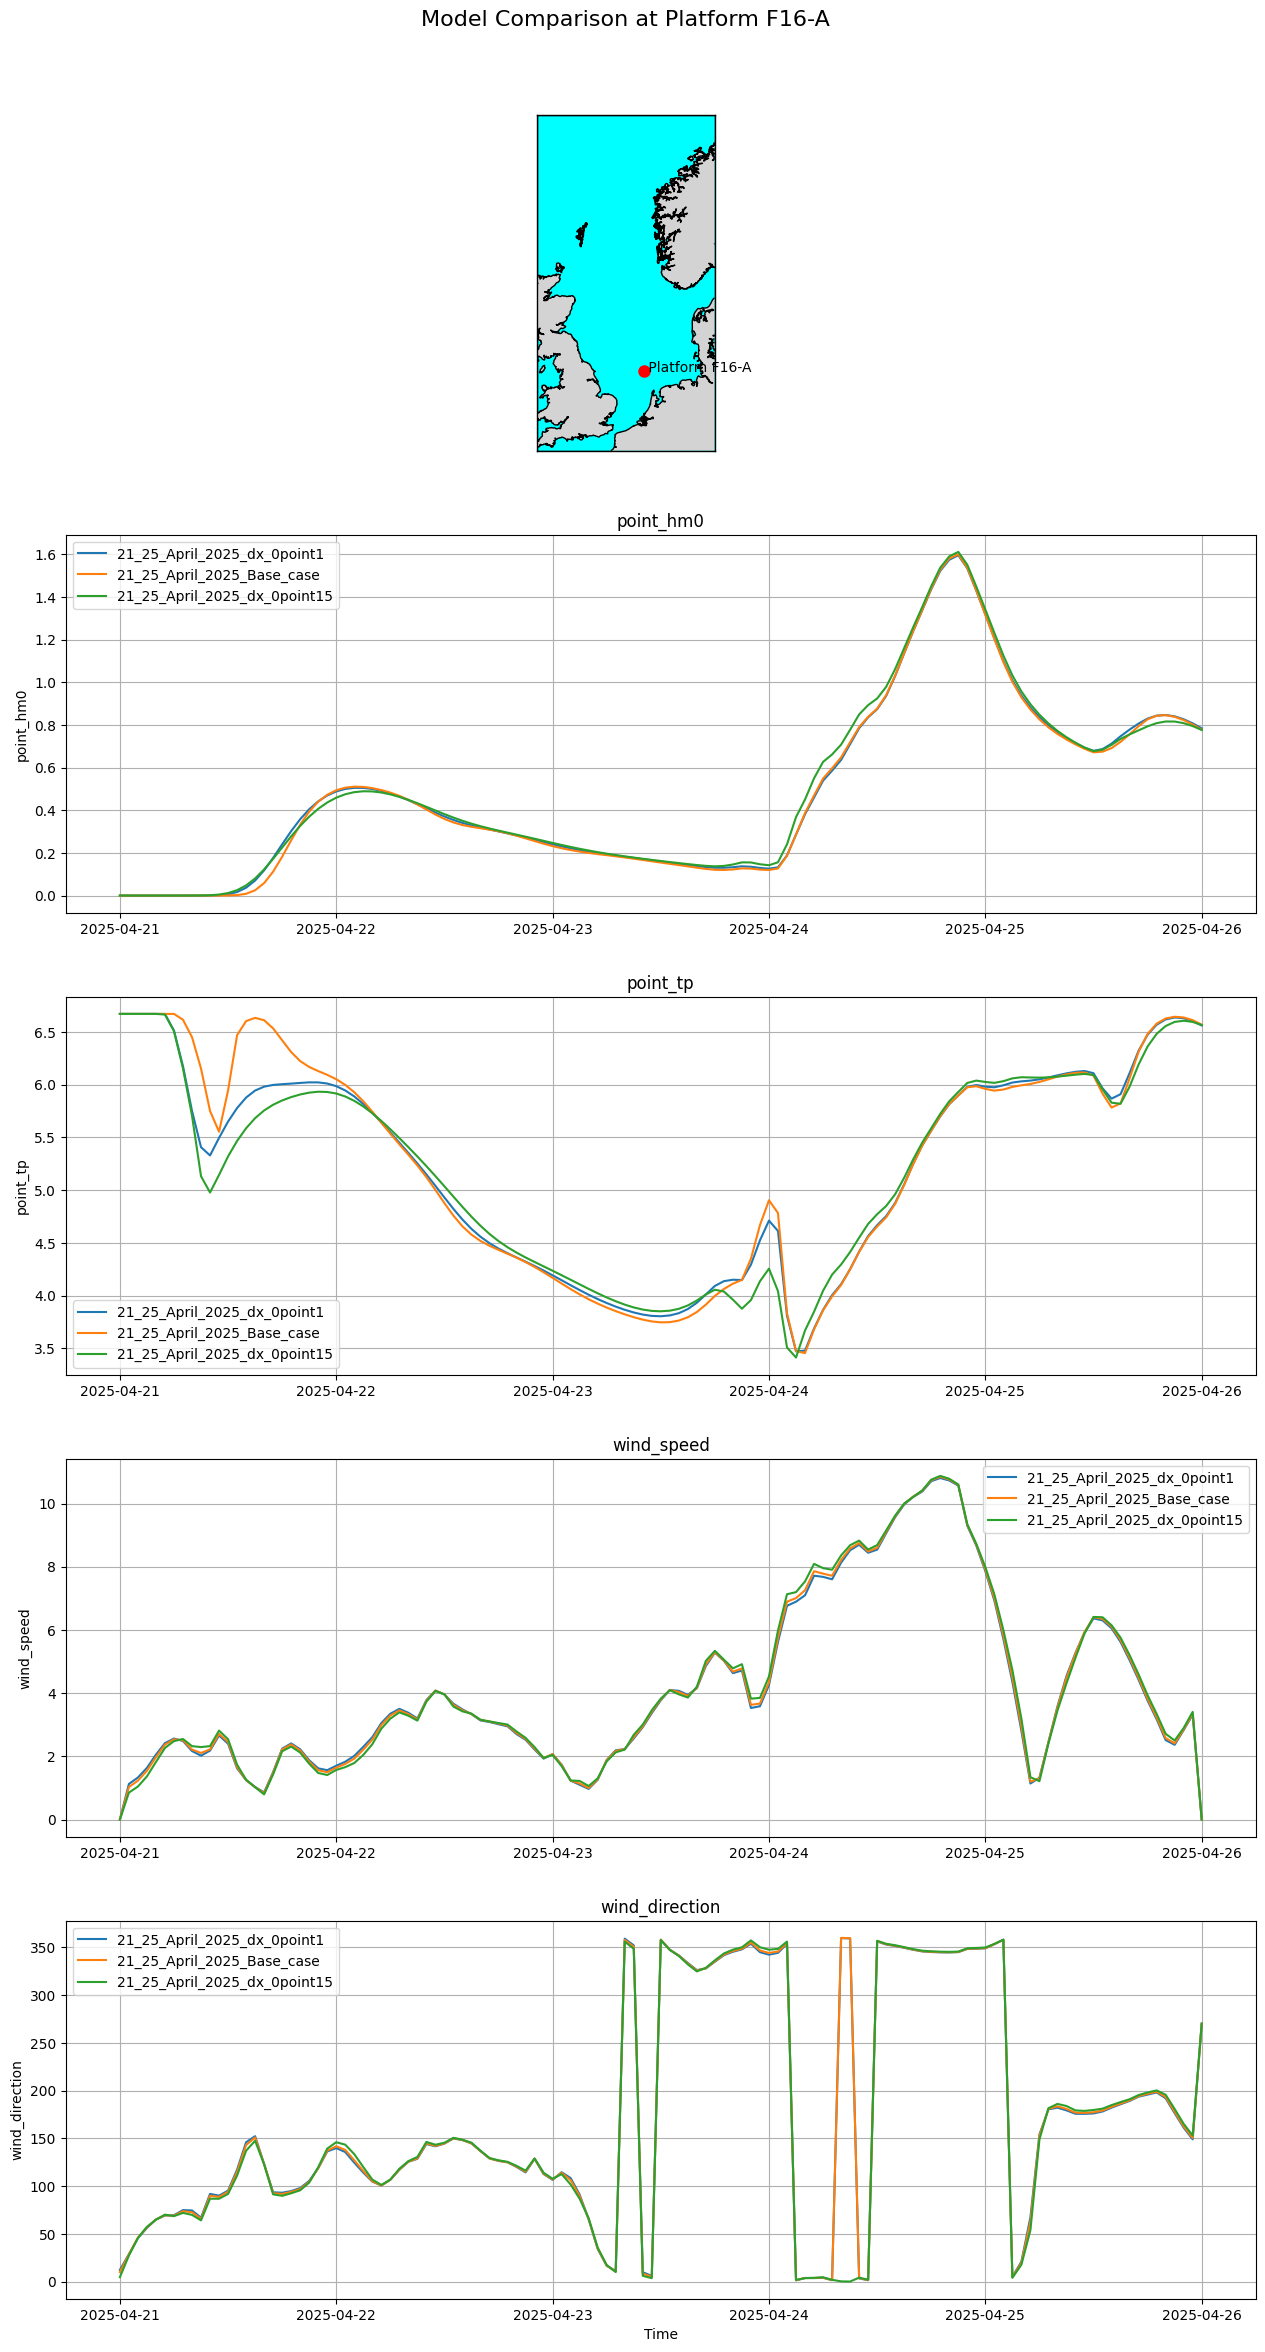

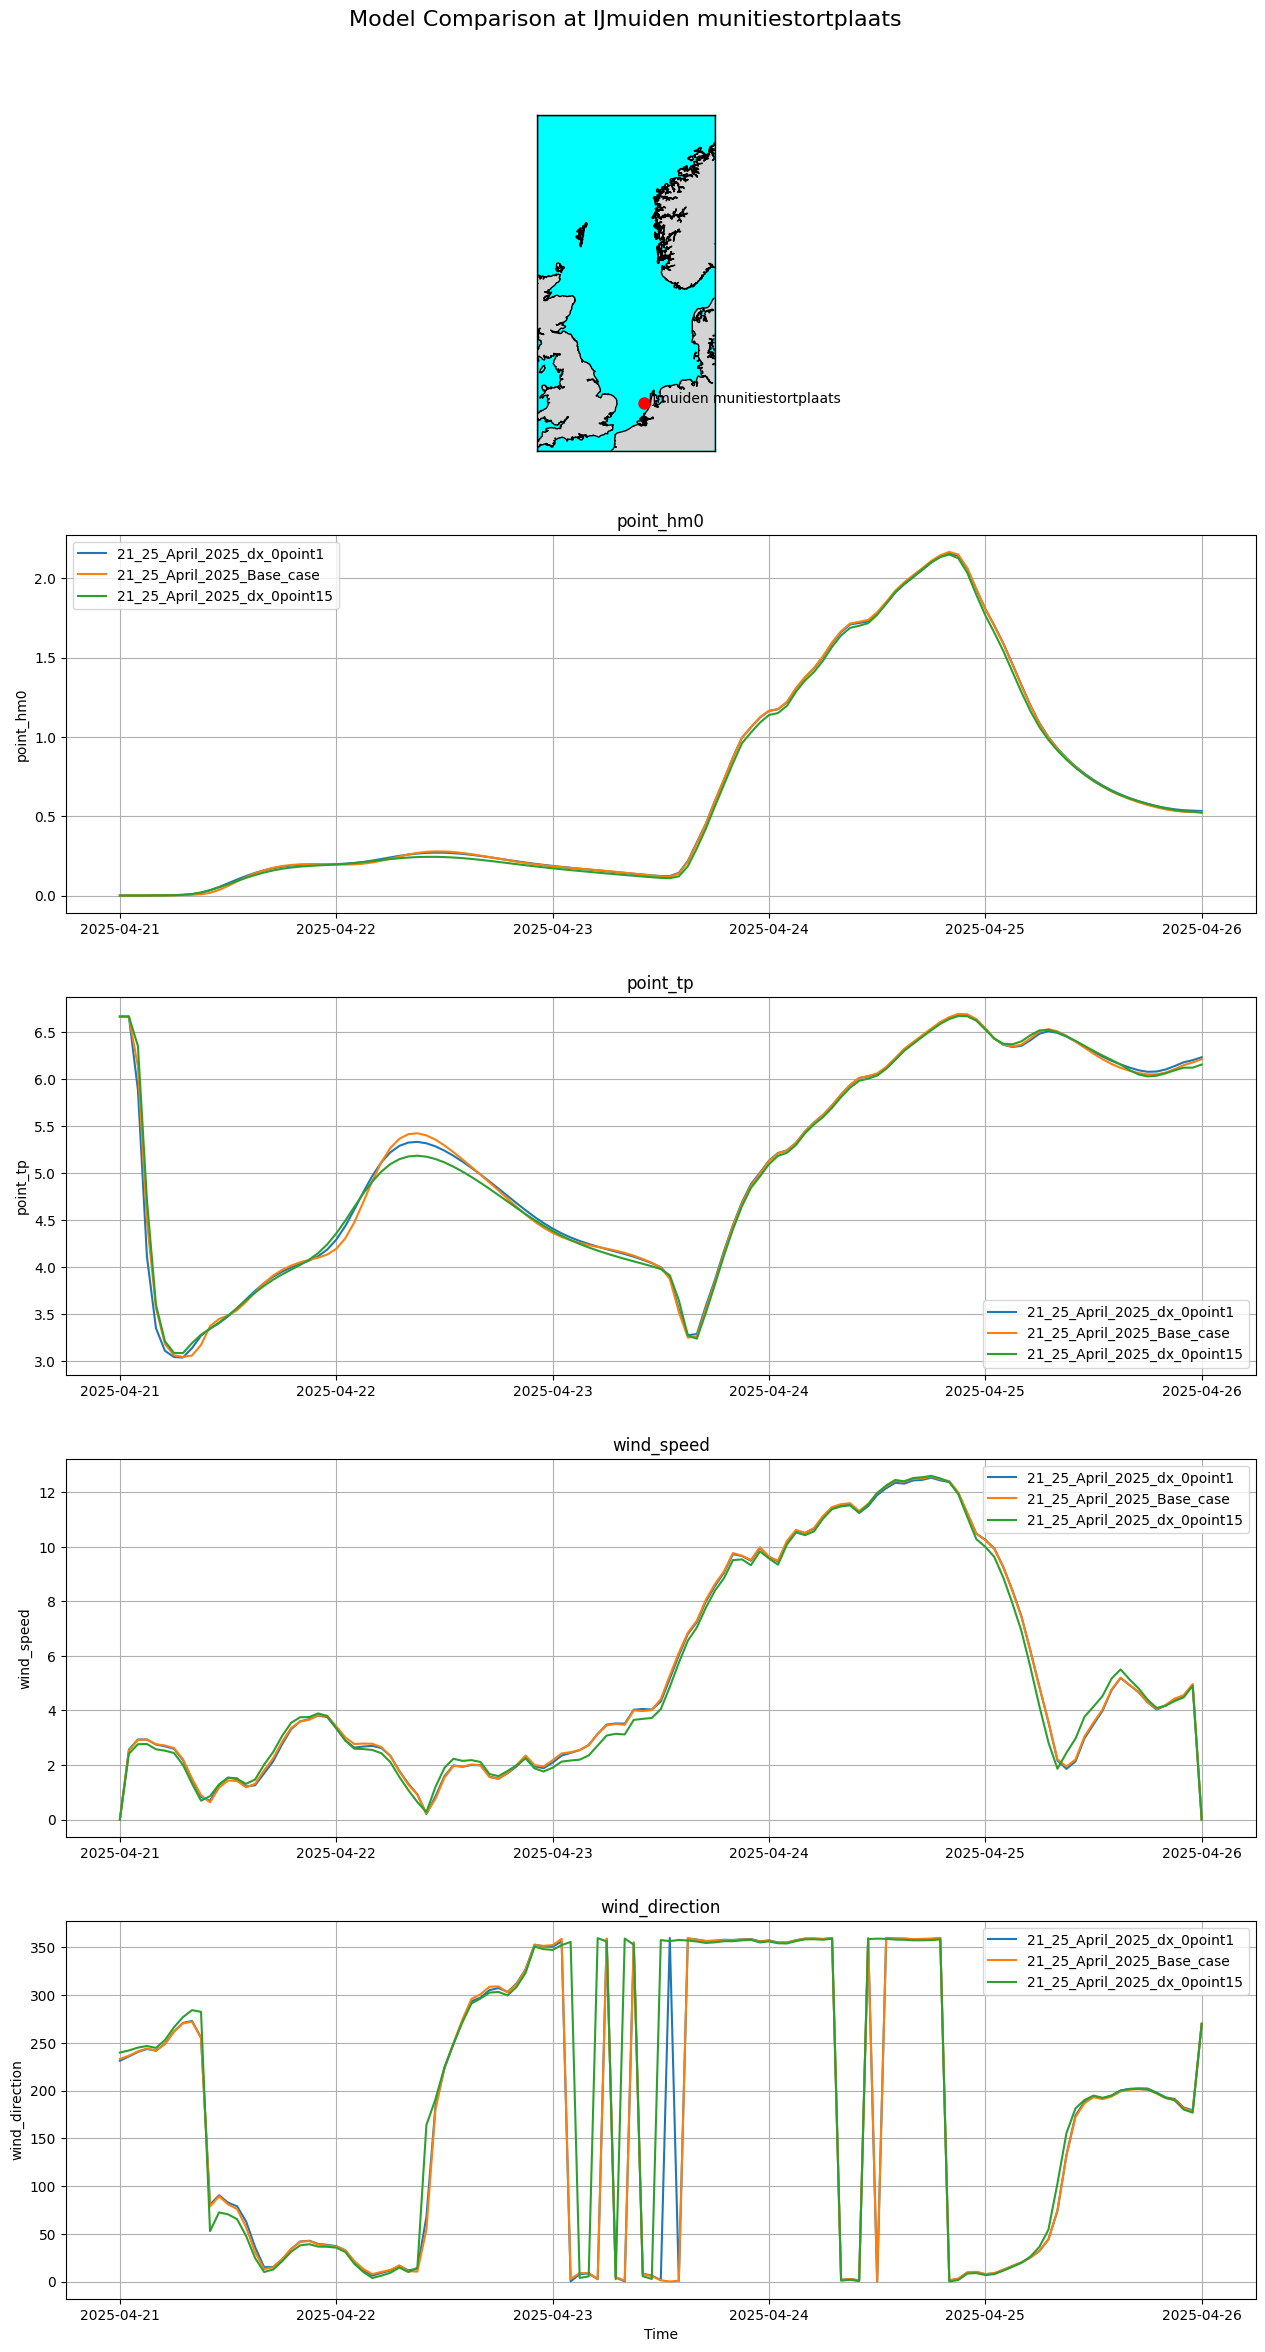

In [7]:
for station_name in station_names:
    plot_station_models_comparison(
        station_name=station_name,
        model_df=data,
        model_vars=["point_hm0", "point_tp", "wind_speed", "wind_direction"],  # or leave None to plot all
        models_to_plot=model_names # or leave None to plot all
    )

In [8]:
def rmse(obs, pred):
    """Root Mean Square Error"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile (e.g., 0.5 for median)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """
    Compute pinball loss for a list of quantiles.
    
    Parameters:
        obs: array-like, observed values
        pred: array-like, predicted values
        quantile_pinball_list: list of quantiles (floats between 0 and 1)
        
    Returns:
        list of pinball losses, one for each quantile
    """
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    losses = []
    for q in quantile_pinball_list:
        delta = obs - pred
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses

def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values

def compute_statistics_against_observations(model_dict, base_case_name, observed_case_names, quantile_pinball, variables):
    """
    Compare a base model to observed datasets using statistics, for selected variables only.

    Parameters:
    - model_dict: dict of model_name -> station -> variable -> values
    - base_case_name: str, name of the base model in model_dict
    - observed_case_names: list of str, names of observed datasets in model_dict
    - quantile_pinball: list of quantiles for pinball loss
    - variables: list of variable names to include in the analysis

    Returns:
    - df_statistics[observed_case][station][variable][statistic] = value
    """
    df_statistics = {}
    base_data = model_dict[base_case_name]

    for obs_name in observed_case_names:
        obs_data = model_dict[obs_name]
        df_statistics[obs_name] = {}

        for station in obs_data:
            if station not in base_data:
                continue  # Skip stations not present in base case
            df_statistics[obs_name][station] = {}

            for variable in variables:
                if variable not in obs_data[station] or variable not in base_data[station]:
                    continue  # Skip variables not present in both obs and base

                obs = obs_data[station][variable]
                pred = base_data[station][variable]

                rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                    obs, pred, quantile_pinball=quantile_pinball, print_stats=False
                )

                df_statistics[obs_name][station][variable] = {
                    'RMSE': rmse_val,
                    'Bias': bias_val,
                    'Scatter Index': si_val,
                }

                for q, ploss in zip(quantile_pinball, pinball_vals):
                    df_statistics[obs_name][station][variable][f'Pinball Loss (q={q})'] = ploss

    return df_statistics

In [9]:
df_statistics = compute_statistics_against_observations(
    model_dict=data,
    base_case_name=base_name,
    observed_case_names=observed_names,
    quantile_pinball=[0.1, 0.5, 0.9],
    variables=["point_hm0", "point_tp"]
)

In [10]:
import pandas as pd
from IPython.display import display, HTML

# Prepare a table comparing statistics for each model run (columns) for all stations and variables (rows)

# Flatten df_statistics to a DataFrame
rows = []
for model_run, stations in df_statistics.items():
    for station, variables in stations.items():
        for variable, stats in variables.items():
            row = {
                'Model Run': model_run,
                'Station': station,
                'Variable': variable
            }
            row.update(stats)
            rows.append(row)

df_stats_table = pd.DataFrame(rows)

# Pivot the table: rows = (Station, Variable, Statistic), columns = Model Run
df_stats_long = df_stats_table.melt(
    id_vars=['Model Run', 'Station', 'Variable'],
    var_name='Statistic',
    value_name='Value'
)

df_stats_pivot = df_stats_long.pivot_table(
    index=['Station', 'Variable', 'Statistic'],
    columns='Model Run',
    values='Value'
)

# Display the table as a scrollable DataFrame

display(HTML(df_stats_pivot.to_html(max_rows=100, max_cols=10, notebook=True, border=1)))

# Map Data

In [11]:
# Open base case and comparison model output (MAP) files
base_map_file = os.path.join(base_path, map_filepaths[0])
comp_map_file = os.path.join(base_path, map_filepaths[1])

def plot_metrics_subplot(lon, lat,
                         rmse, bias, scatter,
                         metric_name, unit,
                         compared_name, base_name):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), constrained_layout=True)

    # Order: RMSE, Scatter Index, Bias
    metrics = [
        ('RMSE', rmse),
        ('Scatter Index', scatter),
        ('Bias', bias)
    ]

    # Custom colormaps

    # Grey to red
    grey_red = LinearSegmentedColormap.from_list("grey_red", ["#e0e0e0", "#8b0000"])
    # Red-grey-blue for bias
    red_grey_blue = LinearSegmentedColormap.from_list("red_grey_blue", ["#8b0000", "#e0e0e0", "#0033cc"])

    cmaps = {
        'RMSE': grey_red,
        'Scatter Index': grey_red,
        'Bias': red_grey_blue
    }

    vmin_vmax = {
        'RMSE': (0, np.nanpercentile(rmse, 99)),
        'Scatter Index': (0, np.nanpercentile(scatter, 99)),
        'Bias': (-np.nanpercentile(np.abs(bias), 99), np.nanpercentile(np.abs(bias), 99))
    }

    for ax, (title, data) in zip(axes, metrics):
        m = Basemap(
            projection='merc',
            llcrnrlat=np.nanmin(lat), urcrnrlat=np.nanmax(lat),
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon),
            resolution='i', ax=ax
        )
        m.drawcoastlines()
        lat_min, lat_max = np.nanmin(lat), np.nanmax(lat)
        lon_min, lon_max = np.nanmin(lon), np.nanmax(lon)
        lat_interval = max(1, int((lat_max - lat_min) // 4))
        lon_interval = max(1, int((lon_max - lon_min) // 4))
        m.drawparallels(
            np.arange(np.floor(lat_min), np.ceil(lat_max) + lat_interval, lat_interval),
            labels=[1, 0, 0, 0], fontsize=10, linewidth=0.5
        )
        m.drawmeridians(
            np.arange(np.floor(lon_min), np.ceil(lon_max) + lon_interval, lon_interval),
            labels=[0, 0, 0, 1], fontsize=10, linewidth=0.5
        )

        x, y = m(lon, lat)

        vmin, vmax = vmin_vmax[title]
        cmap_used = cmaps[title]

        cs = m.pcolormesh(x, y, data, shading='auto', cmap=cmap_used, vmin=vmin, vmax=vmax)
        cbar = m.colorbar(cs, location='bottom', pad=0.4)
        cbar.set_label(f'{title} {metric_name} [{unit}]')

        ax.set_title(f'{title} {metric_name}', fontsize=12)

    fig.suptitle(f'{metric_name}: {compared_name} vs {base_name}', fontsize=14)
    plt.show()



In [12]:
def plot_comparison_map(base_map_path, compared_map_path, plot_swh=True, plot_tp = True):
    base_nc = xu.open_dataset(base_map_file, decode_times=True)
    comp_nc = xu.open_dataset(comp_map_file, decode_times=True)

    base_name = os.path.basename(os.path.dirname(base_map_file))
    compared_name = os.path.basename(os.path.dirname(comp_map_file))

    # Use the same structure for both datasets
    base_modig = {
        "Hm0": base_nc["hm0"],
        "Tp": base_nc["tp"],
        "DIR": base_nc["wavdir"],
        "ds": base_nc["dirspr"],
        "msk": base_nc["msk"],
        "zb": base_nc["zb"]
    }
    comp_modig = {
        "Hm0": comp_nc["hm0"],
        "Tp": comp_nc["tp"],
        "DIR": comp_nc["wavdir"],
        "ds": comp_nc["dirspr"],
        "msk": comp_nc["msk"],
        "zb": comp_nc["zb"]
    }

    # Get coordinates
    base_x = base_nc['x']
    base_y = base_nc['y']
    comp_x = comp_nc['x']
    comp_y = comp_nc['y']

    # 1. Match times once
    base_times = base_modig['Hm0']['time'].values
    comp_times = comp_modig['Hm0']['time'].values
    _, base_idx, comp_idx = np.intersect1d(base_times, comp_times, return_indices=True)

    # Ensure coordinates are unique and sorted
    base_x = np.unique(np.sort(base_x.values))
    base_y = np.unique(np.sort(base_y.values))
    comp_x = np.unique(np.sort(comp_x.values))
    comp_y = np.unique(np.sort(comp_y.values))

    # Extract original lon/lat grids (assumed 2D)
    base_lon = base_nc['x'].values  # shape (n,m)
    base_lat = base_nc['y'].values

    comp_lon = comp_nc['x'].values
    comp_lat = comp_nc['y'].values

    # Overlapping bounding box limits
    lon_min = max(np.nanmin(base_lon), np.nanmin(comp_lon))
    lon_max = min(np.nanmax(base_lon), np.nanmax(comp_lon))
    lat_min = max(np.nanmin(base_lat), np.nanmin(comp_lat))
    lat_max = min(np.nanmax(base_lat), np.nanmax(comp_lat))

    # Estimate grid spacing (mean difference in unique values)
    def mean_spacing(arr):
        unique_sorted = np.sort(np.unique(arr))
        return np.mean(np.diff(unique_sorted))

    base_dx = mean_spacing(base_lon)
    base_dy = mean_spacing(base_lat)
    comp_dx = mean_spacing(comp_lon)
    comp_dy = mean_spacing(comp_lat)

    dx = min(base_dx, comp_dx)
    dy = min(base_dy, comp_dy)

    # Create common lon/lat grid
    common_lon = np.arange(lon_min, lon_max, dx)
    common_lat = np.arange(lat_min, lat_max, dy)
    common_lon_2d, common_lat_2d = np.meshgrid(common_lon, common_lat)

    # Define x_interp and y_interp for use in Basemap plotting
    x_interp = common_lon
    y_interp = common_lat

    def interp_3d_to_common_grid(data_var, orig_lon, orig_lat, target_lon, target_lat):
        """Interpolate a 3D variable (time, n, m) onto target lon/lat grid.
        
        data_var: xarray DataArray or np.ndarray with dims (time, n, m)
        orig_lon, orig_lat: 2D arrays of original lon/lat coords (n,m)
        target_lon, target_lat: 2D arrays of target lon/lat coords
        
        Returns:
            interp_data: np.ndarray of shape (time, target_lat.size, target_lon.size)
        """
        times = data_var.shape[0]
        interp_shape = (times, target_lon.shape[0], target_lon.shape[1])
        interp_data = np.full(interp_shape, np.nan)

        # Flatten original grid points for interpolation
        points = np.vstack((orig_lon.flatten(), orig_lat.flatten())).T

        for t in range(times):
            values = data_var[t].flatten()
            target_points = np.vstack((target_lon.flatten(), target_lat.flatten())).T
            interp_vals = griddata(points, values, target_points, method='nearest')
            interp_data[t] = interp_vals.reshape(target_lon.shape)
        return interp_data

    # Convert to numpy arrays (if not already)
    base_hm0 = base_modig['Hm0'].values  # shape (time, n, m)
    comp_hm0 = comp_modig['Hm0'].values
    base_tp = base_modig['Tp'].values
    comp_tp = comp_modig['Tp'].values

    # Interpolate to common grid
    base_hm0_interp = interp_3d_to_common_grid(base_hm0, base_lon, base_lat, common_lon_2d, common_lat_2d)
    comp_hm0_interp = interp_3d_to_common_grid(comp_hm0, comp_lon, comp_lat, common_lon_2d, common_lat_2d)

    base_tp_interp = interp_3d_to_common_grid(base_tp, base_lon, base_lat, common_lon_2d, common_lat_2d)
    comp_tp_interp = interp_3d_to_common_grid(comp_tp, comp_lon, comp_lat, common_lon_2d, common_lat_2d)


    base_times = base_modig['Hm0']['time'].values
    comp_times = comp_modig['Hm0']['time'].values

    common_times, base_idx, comp_idx = np.intersect1d(base_times, comp_times, return_indices=True)

    # Subset interpolated data by matching times
    base_hm0_interp = base_hm0_interp[base_idx]
    comp_hm0_interp = comp_hm0_interp[comp_idx]

    base_tp_interp = base_tp_interp[base_idx]
    comp_tp_interp = comp_tp_interp[comp_idx]

    # Create masks for valid data points (both datasets finite)
    valid_mask_hm0 = np.isfinite(base_hm0_interp) & np.isfinite(comp_hm0_interp)
    valid_mask_tp = np.isfinite(base_tp_interp) & np.isfinite(comp_tp_interp)

    # Replace invalid points with NaN (to ignore in stats)
    base_hm0_interp[~valid_mask_hm0] = np.nan
    comp_hm0_interp[~valid_mask_hm0] = np.nan

    base_tp_interp[~valid_mask_tp] = np.nan
    comp_tp_interp[~valid_mask_tp] = np.nan

    # RMSE
    rmse_map_swh = np.sqrt(np.nanmean((comp_hm0_interp - base_hm0_interp)**2, axis=0))
    rmse_map_tp = np.sqrt(np.nanmean((comp_tp_interp - base_tp_interp)**2, axis=0))

    # Scatter index
    scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0_interp, axis=0)
    scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp_interp, axis=0)

    # Bias
    bias_map_swh = np.nanmean(comp_hm0_interp - base_hm0_interp, axis=0)
    bias_map_tp = np.nanmean(comp_tp_interp - base_tp_interp, axis=0)

    if plot_swh:
        # Hm0 (SWH)
        plot_metrics_subplot(
            common_lon_2d, common_lat_2d,
            rmse_map_swh, bias_map_swh, scatter_index_map_swh,
            metric_name='Hm0', unit='m',
            compared_name=compared_name, base_name=base_name
        )     

    if plot_tp:
        # Tp
        plot_metrics_subplot(
            common_lon_2d, common_lat_2d,
            rmse_map_tp, bias_map_tp, scatter_index_map_tp,
            metric_name='Tp', unit='s',
            compared_name=compared_name, base_name=base_name
        )


C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:140: RuntimeWarning: Mean of empty slice
  rmse_map_swh = np.sqrt(np.nanmean((comp_hm0_interp - base_hm0_interp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:141: RuntimeWarning: Mean of empty slice
  rmse_map_tp = np.sqrt(np.nanmean((comp_tp_interp - base_tp_interp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:144: RuntimeWarning: Mean of empty slice
  scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:145: RuntimeWarning: Mean of empty slice
  scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:148: RuntimeWarning: Mean of empty slice
  bias_map_swh = np.nanmean(comp_hm0_interp - base_hm0_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:149: RuntimeWarning: Mean of

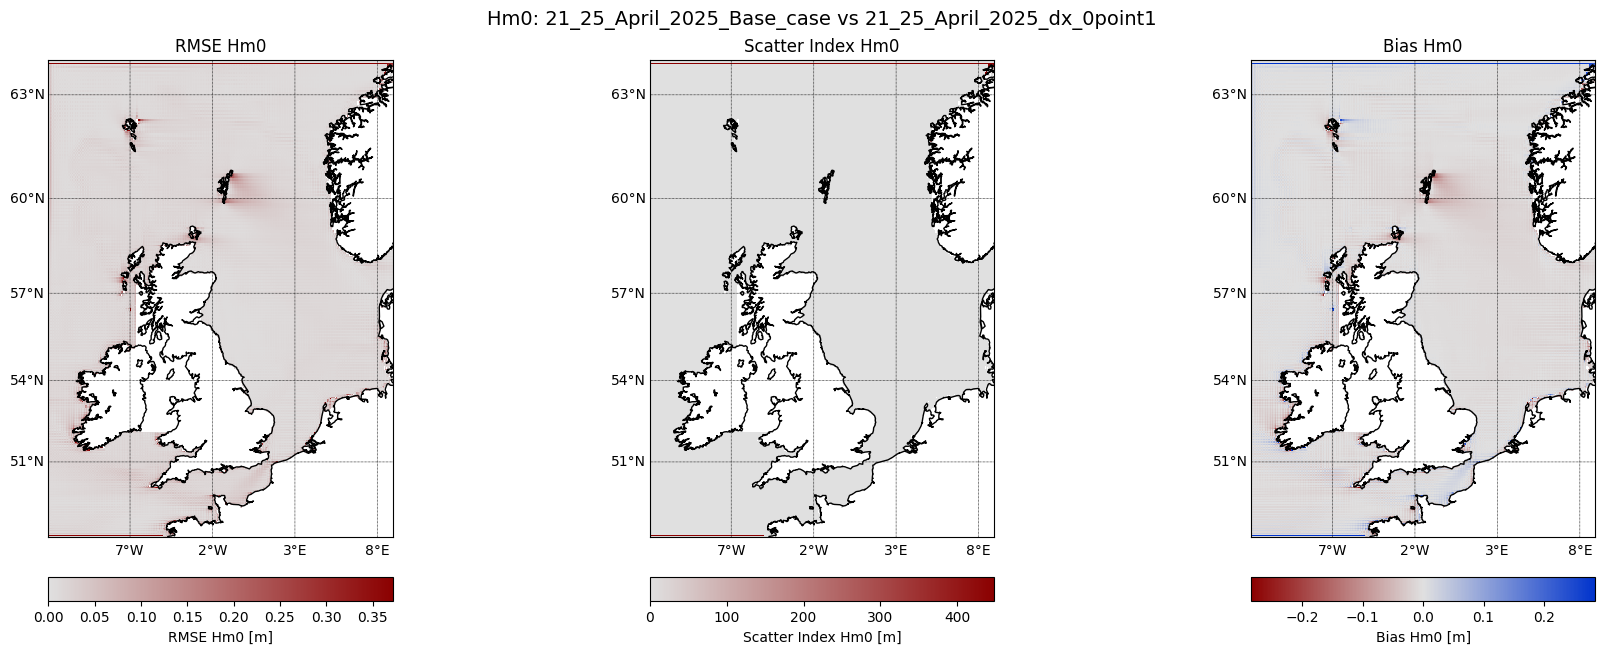

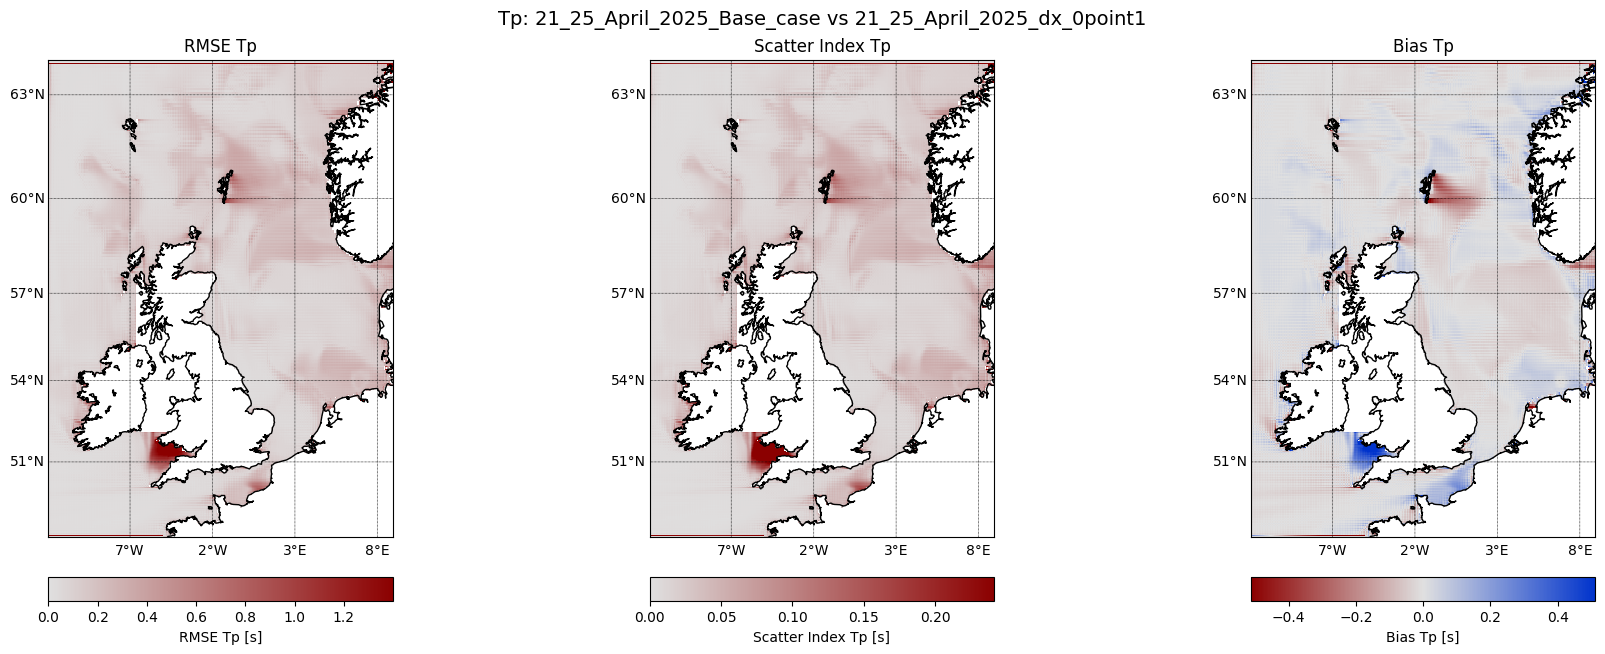

C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:140: RuntimeWarning: Mean of empty slice
  rmse_map_swh = np.sqrt(np.nanmean((comp_hm0_interp - base_hm0_interp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:141: RuntimeWarning: Mean of empty slice
  rmse_map_tp = np.sqrt(np.nanmean((comp_tp_interp - base_tp_interp)**2, axis=0))
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:144: RuntimeWarning: Mean of empty slice
  scatter_index_map_swh = rmse_map_swh / np.nanmean(base_hm0_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:145: RuntimeWarning: Mean of empty slice
  scatter_index_map_tp = rmse_map_tp / np.nanmean(base_tp_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:148: RuntimeWarning: Mean of empty slice
  bias_map_swh = np.nanmean(comp_hm0_interp - base_hm0_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_12472\2044363395.py:149: RuntimeWarning: Mean of

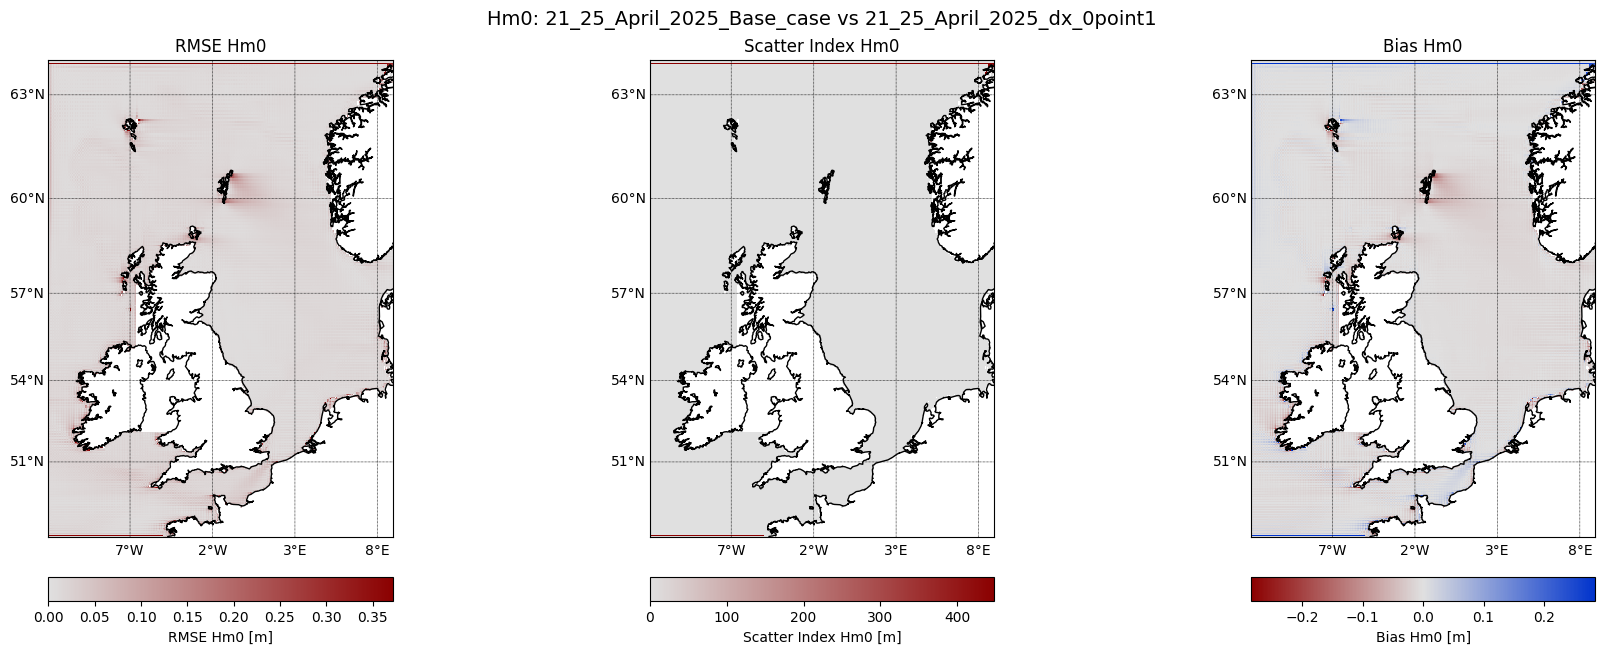

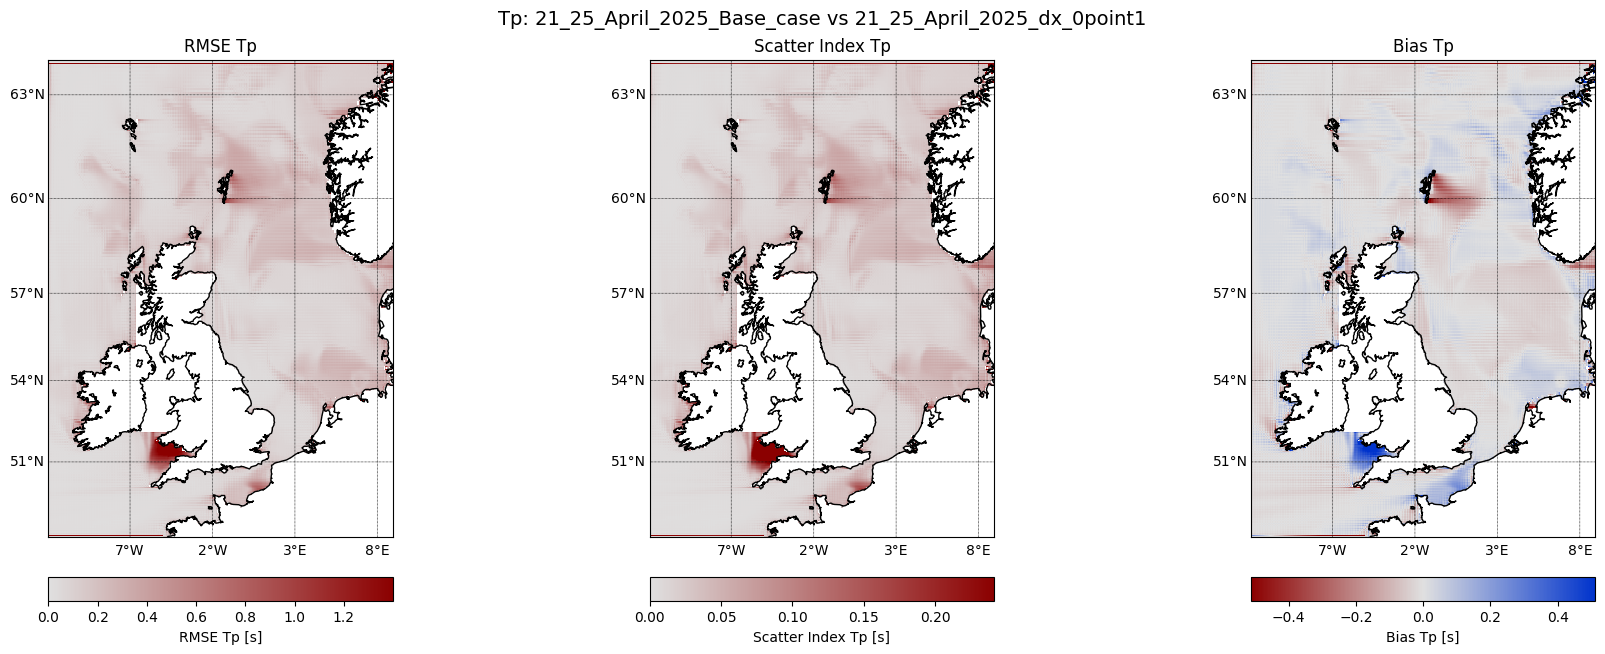

In [13]:
for path in map_filepaths[1:]: # This should take about 4 mins per filepath
    plot_comparison_map(map_filepaths[0], path, plot_swh=True, plot_tp=True)

# Compare stats between 2 models and ERA5

In [15]:
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import os
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from mpl_toolkits.basemap import Basemap
from scipy.spatial import cKDTree

def plot_rmse_diff_maps(base_nc, comp_nc, era5_data, output_dir, run_a_name="Run A", run_b_name="Run B"):
    # Model grid
    model_x_a = base_nc['x'].values
    model_y_a = base_nc['y'].values
    model_x_b = comp_nc['x'].values
    model_y_b = comp_nc['y'].values

    # ERA5 grid
    era5_lats = era5_data.latitude.values
    era5_lons = era5_data.longitude.values
    era5_times = era5_data.valid_time.values

    # Create meshgrid for ERA5 coordinates (lat/lon)
    era5_lon_grid, era5_lat_grid = np.meshgrid(era5_lons, era5_lats)
    shape = (len(era5_lats), len(era5_lons))

    # Prepare model fields
    base_modig = {
        "Hm0": base_nc["hm0"],
        "Tp": base_nc["tp"],
    }
    comp_modig = {
        "Hm0": comp_nc["hm0"],
        "Tp": comp_nc["tp"],
    }

    # Time alignment
    model_times_a = base_modig['Hm0']['time'].values
    model_times_b = comp_modig['Hm0']['time'].values
    _, era5_idx_a, model_idx_a = np.intersect1d(era5_times, model_times_a, return_indices=True)
    _, era5_idx_b, model_idx_b = np.intersect1d(era5_times, model_times_b, return_indices=True)

    # Output arrays
    rmse_map_swh_a = np.full(shape, np.nan)
    rmse_map_swh_b = np.full(shape, np.nan)
    rmse_diff_map_swh = np.full(shape, np.nan)

    rmse_map_tp_a = np.full(shape, np.nan)
    rmse_map_tp_b = np.full(shape, np.nan)
    rmse_diff_map_tp = np.full(shape, np.nan)

    # Pre-extract model fields to avoid repeated I/O
    hm0_all_a = base_modig['Hm0'][:, :, :].values
    tp_all_a = base_modig['Tp'][:, :, :].values
    hm0_all_b = comp_modig['Hm0'][:, :, :].values
    tp_all_b = comp_modig['Tp'][:, :, :].values

    # Prepare KDTree for nearest-neighbor interpolation (handles NaNs)
    model_coords_a = np.column_stack((model_y_a.ravel(), model_x_a.ravel()))
    tree_a = cKDTree(model_coords_a)
    model_coords_b = np.column_stack((model_y_b.ravel(), model_x_b.ravel()))
    tree_b = cKDTree(model_coords_b)

    # Main loop (over grid points)
    for idx, (i, j) in enumerate(np.ndindex(shape)):
        # --- SWH ---
        era5_swh_ts = era5_data['swh'][:, i, j].values

        # Run A: nearest-neighbor, skip NaNs
        _, model_indices_flat_a = tree_a.query([[era5_lats[i], era5_lons[j]]])
        n_a, m_a = np.unravel_index(model_indices_flat_a[0], model_x_a.shape)
        model_hm0_ts_full_a = hm0_all_a[:, n_a, m_a]
        model_hm0_ts_a = np.full_like(era5_swh_ts, np.nan)
        if len(model_idx_a) > 0:
            model_hm0_ts_a[era5_idx_a] = model_hm0_ts_full_a[model_idx_a]
        mask = np.isfinite(model_hm0_ts_a) & np.isfinite(era5_swh_ts)
        if np.any(mask):
            rmse_map_swh_a[i, j] = np.sqrt(np.nanmean((model_hm0_ts_a[mask] - era5_swh_ts[mask]) ** 2))

        # Run B: nearest-neighbor, skip NaNs
        _, model_indices_flat_b = tree_b.query([[era5_lats[i], era5_lons[j]]])
        n_b, m_b = np.unravel_index(model_indices_flat_b[0], model_x_b.shape)
        model_hm0_ts_full_b = hm0_all_b[:, n_b, m_b]
        model_hm0_ts_b = np.full_like(era5_swh_ts, np.nan)
        if len(model_idx_b) > 0:
            model_hm0_ts_b[era5_idx_b] = model_hm0_ts_full_b[model_idx_b]
        mask = np.isfinite(model_hm0_ts_b) & np.isfinite(era5_swh_ts)
        if np.any(mask):
            rmse_map_swh_b[i, j] = np.sqrt(np.nanmean((model_hm0_ts_b[mask] - era5_swh_ts[mask]) ** 2))

        # Difference
        if np.isfinite(rmse_map_swh_a[i, j]) and np.isfinite(rmse_map_swh_b[i, j]):
            rmse_diff_map_swh[i, j] = rmse_map_swh_b[i, j] - rmse_map_swh_a[i, j]

        # --- Tp ---
        era5_mwp_ts = era5_data['mwp'][:, i, j].values

        # Run A
        model_tp_ts_full_a = tp_all_a[:, n_a, m_a]
        model_tp_ts_a = np.full_like(era5_mwp_ts, np.nan)
        if len(model_idx_a) > 0:
            model_tp_ts_a[era5_idx_a] = model_tp_ts_full_a[model_idx_a]
        mask = np.isfinite(model_tp_ts_a) & np.isfinite(era5_mwp_ts)
        if np.any(mask):
            rmse_map_tp_a[i, j] = np.sqrt(np.nanmean((model_tp_ts_a[mask] - era5_mwp_ts[mask]) ** 2))

        # Run B
        model_tp_ts_full_b = tp_all_b[:, n_b, m_b]
        model_tp_ts_b = np.full_like(era5_mwp_ts, np.nan)
        if len(model_idx_b) > 0:
            model_tp_ts_b[era5_idx_b] = model_tp_ts_full_b[model_idx_b]
        mask = np.isfinite(model_tp_ts_b) & np.isfinite(era5_mwp_ts)
        if np.any(mask):
            rmse_map_tp_b[i, j] = np.sqrt(np.nanmean((model_tp_ts_b[mask] - era5_mwp_ts[mask]) ** 2))

        # Difference
        if np.isfinite(rmse_map_tp_a[i, j]) and np.isfinite(rmse_map_tp_b[i, j]):
            rmse_diff_map_tp[i, j] = rmse_map_tp_b[i, j] - rmse_map_tp_a[i, j]

    # --- Plot RMSE difference maps ---
    fig, axs = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)

    # --- SWH RMSE diff ---
    ax = axs[0]
    m_rmse = Basemap(projection='merc',
                     llcrnrlat=era5_lats.min(), urcrnrlat=era5_lats.max(),
                     llcrnrlon=era5_lons.min(), urcrnrlon=era5_lons.max(),
                     resolution='i', ax=ax)
    m_rmse.drawcoastlines()
    ax.set_facecolor('white')
    x_map, y_map = m_rmse(era5_lon_grid, era5_lat_grid)
    vmax = np.nanmax(np.abs(rmse_diff_map_swh))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('red-beige-green', [(1,0,0), (0.96,0.96,0.86), (0,0.7,0)], N=256)
    im1 = m_rmse.pcolormesh(x_map, y_map, rmse_diff_map_swh, cmap=cmap, norm=norm, shading='auto')
    cbar1 = plt.colorbar(im1, ax=ax, orientation='vertical', pad=0.02)
    cbar1.set_label(f'ΔRMSE [m] ({run_b_name} - {run_a_name})')
    ax.set_title(f'ΔRMSE SWH: ({run_b_name} - {run_a_name}) vs ERA5')
    parallels = np.arange(np.floor(era5_lats.min()), np.ceil(era5_lats.max()), 2)
    meridians = np.arange(np.floor(era5_lons.min()), np.ceil(era5_lons.max()), 2)
    m_rmse.drawparallels(parallels, labels=[1,0,0,0], fontsize=10, linewidth=0.5)
    m_rmse.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, linewidth=0.5)

    # --- Tp RMSE diff ---
    ax = axs[1]
    m_rmse = Basemap(projection='merc',
                     llcrnrlat=era5_lats.min(), urcrnrlat=era5_lats.max(),
                     llcrnrlon=era5_lons.min(), urcrnrlon=era5_lons.max(),
                     resolution='i', ax=ax)
    m_rmse.drawcoastlines()
    ax.set_facecolor('white')
    x_map, y_map = m_rmse(era5_lon_grid, era5_lat_grid)
    vmax = np.nanmax(np.abs(rmse_diff_map_tp))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    im2 = m_rmse.pcolormesh(x_map, y_map, rmse_diff_map_tp, cmap=cmap, norm=norm, shading='auto')
    cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', pad=0.02)
    cbar2.set_label(f'ΔRMSE [s] ({run_b_name} - {run_a_name})')
    ax.set_title(f'ΔRMSE Tp: ({run_b_name} - {run_a_name}) vs ERA5')
    m_rmse.drawparallels(parallels, labels=[1,0,0,0], fontsize=10, linewidth=0.5)
    m_rmse.drawmeridians(meridians, labels=[0,0,0,1], fontsize=10, linewidth=0.5)

    # Save plots
    os.makedirs(output_dir, exist_ok=True)
    fig.savefig(os.path.join(output_dir, f"rmse_diff_maps_{run_a_name}_vs_{run_b_name}.png"), dpi=200)
    plt.close(fig)

for i, path in enumerate(map_filepaths[1:], 1):
    output_path = os.path.join(base_path, model_names[i], '1_postprocessing') 
    plot_rmse_diff_maps(
        base_nc=xr.open_dataset(map_filepaths[0]),
        comp_nc=xr.open_dataset(path),
        era5_data=era5_data,
        output_dir=output_path,
        run_a_name=model_names[0],
        run_b_name=model_names[i]
    )
